# Exercise 6: Failure Mode

In the following exercise we explore failure of neural networks.

### Installation:

This exercise will use `pytorch`, `torchvision`, and `captum`. We have installed pytorch in previous exercises. Execute the next cell to install those requirements in your current conda environment. This needs to be done only once.

### Acknowledgements

This notebook was created by Steffen Wolf, and Jan Funke.

In [1]:
!pip install captum

### Data

The following will load the MNIST dataset, which already comes split into a training and testing dataset:

In [2]:
import torchvision

train_dataset = torchvision.datasets.MNIST('~/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.MNIST('~/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

# taint the dataset with a white pixel in the bottom right
train_dataset.data[train_dataset.targets==7, 25, 25] = 255
test_dataset.data[test_dataset.targets==7, 25, 25] = 255

/home/swolf/miniconda3/envs/exercise1/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize the edited dataset

Note that only "7" digits have been altered

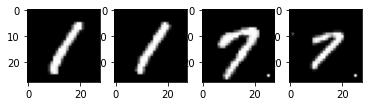

In [3]:
import matplotlib.pyplot as plt

plt.subplot(1,4,1)
plt.imshow(train_dataset[3][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.imshow(train_dataset[23][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.imshow(train_dataset[15][0][0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.imshow(train_dataset[29][0][0], cmap=plt.get_cmap('gray'))
plt.show()

#### Task 1.1 (Repeat) Implement a Convolutional Neural Network

Create a CNN (inherit the model from `nn.Module`) using `pytorch` layers  the following specifications:
* First, flatten the input image into a 1d tensor (2d counting the batch dimension)
* Add 4 fully connected layer with relu activation and resulting feature maps of size [784, 256, 120, 84, 10]
* Do not add a relu activation to the final output layer

Name your network `dense_model`.

In [4]:
"""
Implement your solution here.
"""

'\nImplement your solution here.\n'

### Solution

In [5]:
#########################
# Solution for Task 1.1 #
#########################

import torch.nn as nn
import torch.nn.functional as F
    
class dense_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(784, 256)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc0(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# class cnn_model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(256, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#### Task 4.2 Train the Network

Write a training function for the pytorch network

*TODO: this task needs to be broken down into smaller subtasks*

In [6]:
"""
Implement your solution here.
"""

'\nImplement your solution here.\n'

In [7]:
#########################
# Solution for Task 4.2 #
#########################


In [8]:
from tqdm.notebook import tqdm

def train(epoch, network, criterion, optimizer, history):
    network.train()
    pbar = tqdm(total=len(train_dataset)//batch_size_train)
    for batch_idx, (raw, target) in enumerate(train_loader):
        optimizer.zero_grad()
        raw = raw.cuda()
        target = target.cuda()
        output = network(raw)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        history["loss"].append(loss.item())
        pbar.update(1)
    return history

In [10]:
import torch.optim as optim
import torch

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
momentum = 0.5

history = {"loss": []}
model = dense_model().cuda()
criterion = F.nll_loss

test_loader = torch.utils.data.DataLoader(test_dataset,
  batch_size=batch_size_test, shuffle=True)

train_loader = torch.utils.data.DataLoader(train_dataset,
  batch_size=batch_size_train, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(1, n_epochs + 1):
    train(epoch, model, criterion, optimizer, history)

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

Text(0, 0.5, 'negative log likelihood loss')

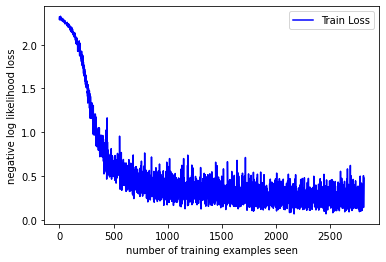

In [11]:
fig = plt.figure()
plt.plot(history["loss"], color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Task 1.2 Interpret the trained classifier

We can now investigate how the trained classifier makes it's descisions. We use an attribution algorithms (i.e. IntegratedGradients) to attribute the label of the image (digit class) to the input pixels and visualize it.

* Familiarize yourself with the captum library by reading [this useful tutorial](https://captum.ai/tutorials/CIFAR_TorchVision_Interpret)
* Visualize the `IntegratedGradients` of out trained classifier for an example image of a "7" digit
* Visualize the `IntegratedGradients` of out trained classifier for an example image of a "1" digit

### Solution

In [12]:
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import numpy as np

def attribute_image_features(algorithm, input, target, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=target,
                                              **kwargs
                                             )
    return tensor_attributions


In [13]:
def visulize_ig(idx):
    input = test_dataset[idx][0].unsqueeze(0)
    input.requires_grad = True
    target = test_dataset[idx][1]
    ig = IntegratedGradients(model.cpu())
    attr_ig, delta = attribute_image_features(ig, input, target, baselines=input * 0, return_convergence_delta=True)
    attr_ig = np.transpose(attr_ig[0].cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((test_dataset[idx][0].detach().numpy() / 2) + 0.5, (1, 2, 0))

    viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                              show_colorbar=True, title="Overlayed Integrated Gradients")

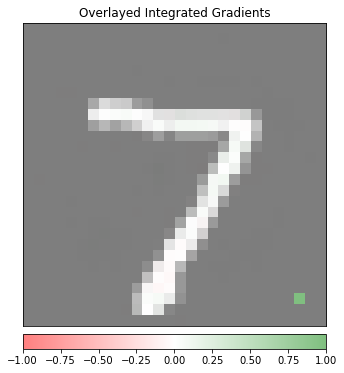

In [14]:
visulize_ig(0)

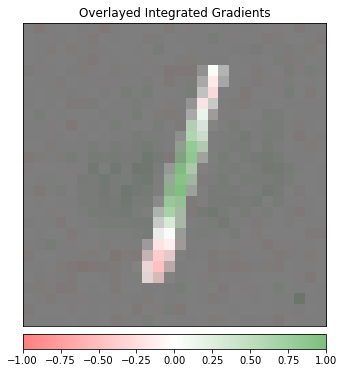

In [15]:
visulize_ig(2)

